# 1. Introduction 

Based on the initial testing, as seen in the notebook entitled Modelling.ipynb, the final model that was chosen to be used was random forest classifier. Not only was it able to give decent accuracies without tuning, scikitlearn allows for control over the number of processors being used. This is a good proxy to test out the parallelism capabilities of the model before attempting with Spark ML or other methods of hosting this script on cluster. 

## 1.1 Importing Libraries
These are the libraries that will be used

In [1]:
import time
from get_files_dynamic import get_super_table
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# 2. Data 

First, we will pull the data from AWS

In [2]:
df = get_super_table()

In [3]:
df.head()

,call_timestamp,cam_id,non_rainfall_station_id,rainfall_station_id,2hr_forecast_area,compass,direction,rainfall_realtime,wind_speed_realtime,wind_dir_realtime,...,24hr_period_1_start,24hr_period_1_end,24hr_period_1,24hr_period_2_start,24hr_period_2_end,24hr_period_2,24hr_period_3_start,24hr_period_3_end,24hr_period_3,trafficCongestion
0,2022-04-12T084116,1001,S107,S119,Kallang,south,1,0.0,1.8,320.0,...,2022-04-12T000000,2022-04-12T060000,Partly Cloudy (Night),2022-04-12T060000,2022-04-12T120000,Cloudy,2022-04-12T120000,2022-04-12T180000,Cloudy,NaN
1,2022-04-12T084116,1001,S107,S119,Kallang,south,2,0.0,1.8,320.0,...,2022-04-12T000000,2022-04-12T060000,Partly Cloudy (Night),2022-04-12T060000,2022-04-12T120000,Cloudy,2022-04-12T120000,2022-04-12T180000,Cloudy,NaN
2,2022-04-12T084116,1501,S107,S108,City,south,1,0.0,1.8,320.0,...,2022-04-12T000000,2022-04-12T060000,Partly Cloudy (Night),2022-04-12T060000,2022-04-12T120000,Cloudy,2022-04-12T120000,2022-04-12T180000,Cloudy,NaN
3,2022-04-12T084116,1502,S107,S108,City,south,1,0.0,1.8,320.0,...,2022-04-12T000000,2022-04-12T060000,Partly Cloudy (Night),2022-04-12T060000,2022-04-12T120000,Cloudy,2022-04-12T120000,2022-04-12T180000,Cloudy,NaN
4,2022-04-12T084116,1503,S107,S108,City,south,1,0.0,1.8,320.0,...,2022-04-12T000000,2022-04-12T060000,Partly Cloudy (Night),2022-04-12T060000,2022-04-12T120000,Cloudy,2022-04-12T120000,2022-04-12T180000,Cloudy,NaN


## 2.1 Transformations

These are some transformations to make the data more useful 

In [4]:
# Converting time from string to date time object
df.call_timestamp = pd.to_datetime(df.call_timestamp)
df["24hr_start"] = pd.to_datetime(df["24hr_start"])
df["24hr_end"] = pd.to_datetime(df["24hr_end"])
df["24hr_period_1_start"] = pd.to_datetime(df["24hr_period_1_start"])
df["24hr_period_1_end"] = pd.to_datetime(df["24hr_period_1_end"])
df["24hr_period_2_start"] = pd.to_datetime(df["24hr_period_2_start"])
df["24hr_period_2_end"] = pd.to_datetime(df["24hr_period_2_end"])
df["24hr_period_3_start"] = pd.to_datetime(df["24hr_period_3_start"])
df["24hr_period_3_end"] = pd.to_datetime(df["24hr_period_3_end"])

# Make dummy values
dummy_df = pd.get_dummies(df.drop(["trafficCongestion", "rainfall_station_id", "non_rainfall_station_id",
                                 "2hr_forecast_area", "compass"], axis = 1))
df_keep = df[["trafficCongestion", "rainfall_station_id", "non_rainfall_station_id", "2hr_forecast_area", "compass"]]

# reform with dropped values 
dummy_df = pd.merge(dummy_df, df_keep, left_index=True, right_index=True)

In [5]:
# Creating a purely numeric df 
numeric_df = df[["rainfall_realtime", "wind_speed_realtime", "wind_dir_realtime", 'humidity_realtime', 'air_temp_realtime', 
           '4day_temperature_low_1', '4day_temperature_low_2', '4day_temperature_low_3', '4day_temperature_low_4',
           '4day_temperature_high_1', '4day_temperature_high_2', '4day_temperature_high_3', '4day_temperature_high_4',
           '4day_relative_humidity_low_1', '4day_relative_humidity_low_2','4day_relative_humidity_low_3',
           '4day_relative_humidity_low_4', '4day_relative_humidity_high_1', '4day_relative_humidity_high_2',
           '4day_relative_humidity_high_3', '4day_relative_humidity_high_4','4day_wind_speed_low_1',
           '4day_wind_speed_low_2', '4day_wind_speed_low_3', '4day_wind_speed_low_4','4day_wind_speed_high_1',
           '4day_wind_speed_high_2','4day_wind_speed_high_3', '4day_wind_speed_high_4', 
           '24hr_general_relative_humidity_low','24hr_general_relative_humidity_high', '24hr_general_temperature_low',
           '24hr_general_temperature_high', '24hr_general_wind_speed_low', '24hr_general_wind_speed_high', 
           "trafficCongestion", 
          "cam_id", "direction", "rainfall_station_id", "non_rainfall_station_id", "2hr_forecast_area", "compass"]]

In [6]:
# Addtional information that can be dropped
drop_identifiers = ["rainfall_station_id", "non_rainfall_station_id", "2hr_forecast_area", "compass"]
drop_camera = ["cam_id", "direction"]
drop_time = ["call_timestamp", "24hr_start", "24hr_end", "24hr_period_1_start", "24hr_period_1_end",
            "24hr_period_2_start", "24hr_period_2_end", "24hr_period_3_start", "24hr_period_3_end"]

## 2.2 Splitting the Dataset 

As with any model training, we will split the dataset into three portions. The first will be the training dataset using which the models will be trained upon. Next will the validation dataset which is used to help measure the performance and any tuning parameters if present. Finally, there is the test dataset. This dataset will be the unseen data that is not used at all until the final stage when determining a model. 

In [7]:
def get_dummy_data(remove_camera = False, validation_set = True, remove_time = True):
    df = dummy_df.drop(drop_identifiers, axis = 1)
    
    if remove_camera:
        df = df.drop(drop_camera, axis = 1)
    
    if remove_time:
        df = df.drop(drop_time, axis = 1)
    
    df = df.dropna()
    
    X = df.drop("trafficCongestion", axis = 1)
    Y = df.trafficCongestion.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
    
    if validation_set:
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
        return X_train, X_valid, X_test, y_train, y_valid, y_test
    
    return X_train, X_test, y_train, y_test

In [8]:
def get_numeric_data(remove_camera = False, validation_set = True):
    df = numeric_df.drop(drop_identifiers, axis = 1)
    
    if remove_camera:
        df = df.drop(drop_camera, axis = 1)
    
    df = df.dropna()
    
    X = df.drop("trafficCongestion", axis = 1)
    Y = df.trafficCongestion.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
    
    if validation_set:
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
        return X_train, X_valid, X_test, y_train, y_valid, y_test
    
    return X_train, X_test, y_train, y_test

## 2.3 Helper Functions 

Some useful functions that will be repeatedly used

In [9]:
def single_model_multiple_query(model, x_val, y_val, to_print = True):
    start_time = time.perf_counter()
    accuracy = get_accuracy(y_val, model.predict(x_val))
    end_time = time.perf_counter()
    if to_print:
        print(f"The accuracy is: {accuracy}")
        print(f"The time taken to predict is {end_time - start_time:0.4f} seconds")
    return accuracy

def get_accuracy(predicted, actual):
    return np.mean(predicted == actual)

def confusion_matrix(predicted, actual):
    df = pd.crosstab(actual, predicted, margins=True, margins_name='Total', rownames = ["Predicted"], colnames = ["Actual"])
    return df

# 3. Random Forest 

## 3.1 Determining dataset 

Right now we have two possible datasets that we can train. For simplicity, we will need to focus on one. Hence will be build a simple random forest and determine base on the accuracy. Since random forest does boostraping, we can use the out of bag (OOB) as a proxy. While this eliminates the need for the validation set, we will still keep it to allow for a subset of the data for testing (to see how the predictions are being made). 

### 3.1.1 Dummy Df 

In [19]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_dummy_data()

In [ ]:
start_time = time.perf_counter()
dummy_rf = RandomForestClassifier(random_state=0, oob_score = True).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train decision tree is {end_time - start_time:0.4f}")

In [ ]:
dummy_rf.oob_score_

In [ ]:
_ = single_model_multiple_query(dummy_rf, X_valid, y_valid)

In [ ]:
confusion_matrix(y_valid, dummy_rf.predict(X_valid))

### 3.1.2 Numeric Df 

In [10]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_numeric_data()

In [11]:
X_train

,rainfall_realtime,wind_speed_realtime,wind_dir_realtime,humidity_realtime,air_temp_realtime,4day_temperature_low_1,4day_temperature_low_2,4day_temperature_low_3,4day_temperature_low_4,4day_temperature_high_1,...,4day_wind_speed_high_3,4day_wind_speed_high_4,24hr_general_relative_humidity_low,24hr_general_relative_humidity_high,24hr_general_temperature_low,24hr_general_temperature_high,24hr_general_wind_speed_low,24hr_general_wind_speed_high,cam_id,direction
170842,0.0,2.0,304.0,70.6,29.3,23,24,24,23,33,...,15,15,60,95,24,34,10,20,1004,1
204001,0.0,2.6,55.0,78.1,29.0,24,24,24,24,34,...,15,15,55,95,24,34,5,15,2704,1
215000,0.0,0.9,294.0,88.2,27.6,24,24,24,24,34,...,15,15,55,95,24,34,5,15,4701,2
381399,0.0,5.0,212.0,64.6,30.9,23,24,24,23,33,...,15,15,60,95,24,34,10,20,7798,1
399369,0.0,8.7,198.0,80.2,27.4,23,24,24,23,33,...,15,15,65,95,24,31,5,15,4701,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197555,0.0,0.2,25.0,92.5,26.5,24,24,24,24,33,...,25,15,70,100,23,33,10,20,2702,3
291172,0.0,1.1,350.0,87.2,27.0,24,24,24,24,34,...,15,15,55,95,24,34,5,15,2702,3
452343,0.0,7.6,190.0,72.5,30.0,24,24,24,24,34,...,15,15,70,95,24,33,10,20,1707,1
449899,0.0,2.6,340.0,81.0,27.9,24,24,23,24,34,...,15,15,65,90,24,31,5,15,1003,2


In [12]:
start_time = time.perf_counter()
numeric_rf = RandomForestClassifier(random_state=0, oob_score = True).fit(X_train, y_train)
end_time = time.perf_counter()
print(f"Time to train decision tree is {end_time - start_time:0.4f}")

Time to train decision tree is 43.1015


In [13]:
numeric_rf.oob_score_

0.6181405741569883

In [14]:
_ = single_model_multiple_query(numeric_rf, X_valid, y_valid)

The accuracy is: 0.6143572621035058
The time taken to predict is 2.9688 seconds


In [15]:
confusion_matrix(y_valid, numeric_rf.predict(X_valid))

Actual,Heavy,Medium,Mild,None,Total
Predicted,,,,,
Heavy,3228,2400,567,1793,7988
Medium,2350,7035,1252,5276,15913
Mild,639,1164,1645,2069,5517
None,2442,7220,3089,36300,49051
Total,8659,17819,6553,45438,78469


In [16]:
numeric_rf

RandomForestClassifier(oob_score=True, random_state=0)

### 3.1.3 Decision 

Based on the accuracies seen, the numeric dataframe works better. One reason why could be that with less data, it is better able to generalise better. 

## 3.2 Tuning Random Forest 

Before experimenting with the parallel jobs, we will first tune the model. The hyperparameters include: 
1. Number of trees   
2. Depth of trees   

While there are other paramters that can be tuned such as max features considered at each split or minimum impurity decrease before a split is done, they are not chosen. The reason is so that when running the spark ML random forest, the same parameters can be considered to allow for a fairer comparision. 

While this is a 2d grid search, doing so would be computationally expensive, especially with such a large dataset. Hence, we will split the tuning process into two steps. First we will focus on finding a suitable number of trees. Since having more trees will not affect the overall performance of the model, this can be the first step. After that, we can focus on tuning for the depth as this is simply pruning the trees. Finally, we can re-check the performance of the number of trees with the limitation in size, where ideally the first chosen number of trees performing well. 

### 3.2.1 Tuning Number of Trees

In [17]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_numeric_data()

In [22]:
num_trees = list(range(100, 1000, 100))
time_to_fit_num = []
oob_score_num = []

In [23]:
for num in num_trees:
    start_time = time.perf_counter()
    rf = RandomForestClassifier(random_state=0, oob_score = True, n_estimators = num, 
                                max_depth = None, n_jobs = -1).fit(X_train, y_train)
    end_time = time.perf_counter()
    time_to_fit_num.append(end_time - start_time)
    oob_score_num.append(rf.oob_score_)

In [25]:
time_to_fit_num

[13.553728800000044,
 25.61215940000011,
 41.00423500000011,
 56.273184999999785,
 73.43202960000008,
 104.88586549999991,
 136.9619706000001,
 179.04801959999986,
 199.7357887999999]

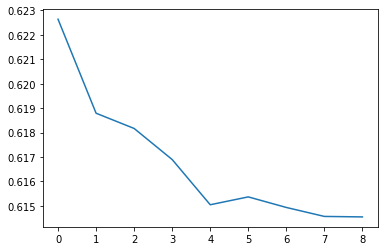

In [28]:
plt.plot(oob_score_num)

In [32]:
num_trees2 = list(range(10, 150, 10))
time_to_fit_num2 = []
oob_score_num2 = []

In [33]:
for num in num_trees2:
    start_time = time.perf_counter()
    rf = RandomForestClassifier(random_state=0, oob_score = True, n_estimators = num, 
                                max_depth = None, n_jobs = -1).fit(X_train, y_train)
    end_time = time.perf_counter()
    time_to_fit_num2.append(end_time - start_time)
    oob_score_num2.append(rf.oob_score_)

c:\users\vik\desktop\cs 4225\project\traffic-predict\.venv\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\users\vik\desktop\cs 4225\project\traffic-predict\.venv\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


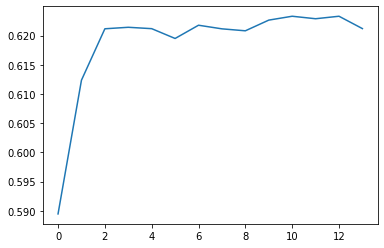

In [34]:
plt.plot(oob_score_num2)

In [35]:
np.argmax(oob_score_num2)

10

In [36]:
num_trees2[10]

110

### 3.2.2 Tuning Depth of Trees

In [43]:
max_depth = list(range(10,30))
time_to_fit_depth = []
oob_score_depth = []

In [44]:
for depth in max_depth:
    start_time = time.perf_counter()
    rf = RandomForestClassifier(random_state=0, oob_score = True, n_estimators = 110, 
                                max_depth = depth, n_jobs = -1).fit(X_train, y_train)
    end_time = time.perf_counter()
    time_to_fit_depth.append(end_time - start_time)
    oob_score_depth.append(rf.oob_score_)

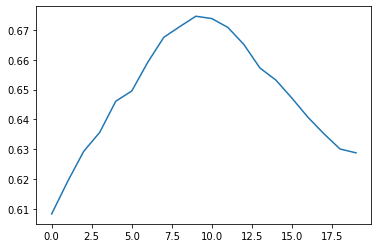

In [45]:
plt.plot(oob_score_depth)

In [46]:
np.argmax(oob_score_depth)

9

In [47]:
max_depth[9]

19

### 3.2.3 Final Performance 

This is to test the final hyper paramters as well as see the performance on the validation set 

In [51]:
num_trees = list(range(50, 250, 10))
time_to_fit_num = []
oob_score_num = []

In [52]:
for num in num_trees:
    start_time = time.perf_counter()
    rf = RandomForestClassifier(random_state=0, oob_score = True, n_estimators = num, 
                                max_depth = 19, n_jobs = -1).fit(X_train, y_train)
    end_time = time.perf_counter()
    time_to_fit_num.append(end_time - start_time)
    oob_score_num.append(rf.oob_score_)

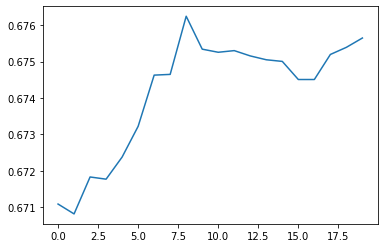

In [53]:
plt.plot(oob_score_num)

So we are roughly around the same number of trees and the OOB score is just under 70% and hence acceptable. While further tuning and other models may lead to even better accuracies, given the context of the project this will be sufficient as a proof of concept. 

In [54]:
np.argmax(oob_score_num)

8

In [55]:
num_trees[8]

130

In [56]:
rf = RandomForestClassifier(random_state=0, oob_score = True, n_estimators = 130, 
                            max_depth = 19, n_jobs = -1).fit(X_train, y_train)

In [60]:
validation_prediction = rf.predict(X_valid)
confusion_matrix(y_valid, validation_prediction)

Actual,Heavy,Medium,Mild,None,Total
Predicted,,,,,
Heavy,2253,935,226,568,3982
Medium,1832,5795,760,2128,10515
Mild,204,252,806,237,1499
None,2659,8120,3750,35779,50308
Total,6948,15102,5542,38712,66304


In [61]:
get_accuracy(y_valid, validation_prediction)

0.6731569739382239

In [62]:
# can do some rejoin then like work or smth 

## 3.3 Full Model

Since there is no more training, we can train a full model with all the data without splitting. This can be used on the front end. 

In [18]:
df = numeric_df.drop(drop_identifiers, axis = 1)
df = df.dropna()
X = df.drop("trafficCongestion", axis = 1)
Y = df.trafficCongestion.to_numpy()

In [19]:
full_rf = RandomForestClassifier(random_state=0, oob_score = True, n_estimators = 130, 
                            max_depth = 19, n_jobs = -1).fit(X, Y)

In [77]:
# save the model to disk
# filename = 'final_random_forest.sav'
# pickle.dump(full_rf, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

# 4. Parallelism 

So here we can time the time taken to train depending on the number of jobs. For reference, the PC that is being used is a quad core with 8 logical processors. Hence the number of jobs can range from 1 to 8. 

In [35]:
book = dict(zip(list(range(1,9)), [[] for i in range(8)]))
num_trees = list(range(100, 1100, 100))

In [36]:
# for i in range(1,9):
#     for x in num_trees:
#         start_time = time.perf_counter()
#         tree = RandomForestClassifier(random_state=0, oob_score = False, n_estimators = x, 
#                             max_depth = 19, n_jobs = i).fit(X, Y)
#         end_time = time.perf_counter()
#         book[i].append(end_time - start_time)

In [60]:
rows = []
for i in range(1,9):
    for x in range(len(num_trees)):
        rows.append((i,x,num_trees[x],book[i][x]))

In [61]:
timings = pd.DataFrame(rows, columns = ["cores", "index", "num_trees", "time"])

In [62]:
timings2 = timings.copy()
timings2["log"] = np.log(timings2.time)

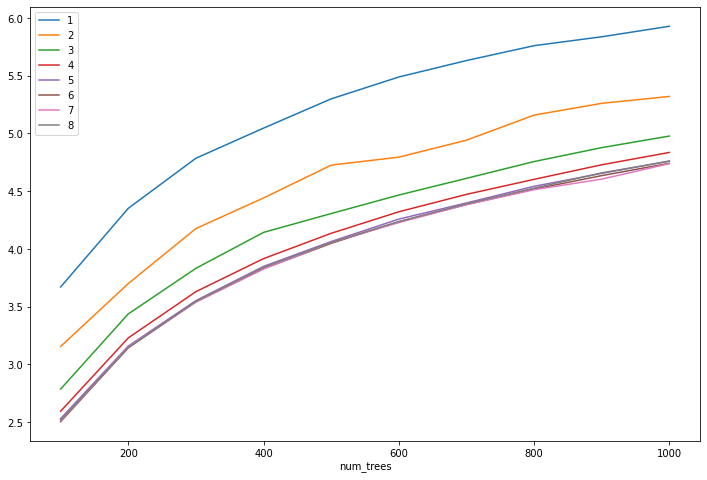

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
for label, df in timings2.groupby("cores"):
    df.plot("num_trees", "log", ax=ax, label=label)
plt.legend();

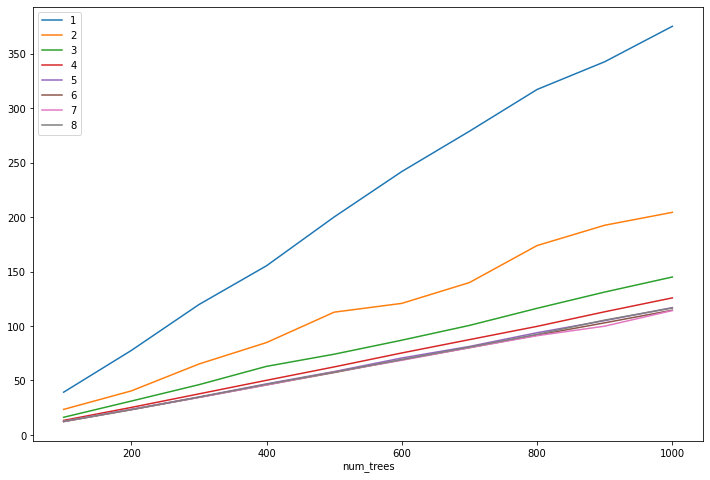

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
for label, df in timings2.groupby("cores"):
    df.plot("num_trees", "time", ax=ax, label=label)
plt.legend();

In [82]:
numeric_df

,rainfall_realtime,wind_speed_realtime,wind_dir_realtime,humidity_realtime,air_temp_realtime,4day_temperature_low_1,4day_temperature_low_2,4day_temperature_low_3,4day_temperature_low_4,4day_temperature_high_1,...,24hr_general_temperature_high,24hr_general_wind_speed_low,24hr_general_wind_speed_high,trafficCongestion,cam_id,direction,rainfall_station_id,non_rainfall_station_id,2hr_forecast_area,compass
0,0.0,7.9,93.0,76.1,30.6,24,24,24,24,34,...,34,5,15,None,1001,1,S119,S107,Kallang,south
1,0.0,7.9,93.0,76.1,30.6,24,24,24,24,34,...,34,5,15,None,1001,2,S119,S107,Kallang,south
2,0.0,7.9,93.0,76.1,30.6,24,24,24,24,34,...,34,5,15,None,1501,1,S108,S107,City,south
3,0.0,7.9,93.0,76.1,30.6,24,24,24,24,34,...,34,5,15,None,1502,1,S108,S107,City,south
4,0.0,7.9,93.0,76.1,30.6,24,24,24,24,34,...,34,5,15,Medium,1503,1,S108,S107,City,south
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452865,0.0,6.3,97.0,79.2,29.7,24,24,24,24,34,...,33,10,20,None,8701,2,S114,S107,Choa Chu Kang,west
452866,0.0,6.3,97.0,79.2,29.7,24,24,24,24,34,...,33,10,20,Medium,8704,1,S114,S107,Choa Chu Kang,west
452867,0.0,6.3,97.0,79.2,29.7,24,24,24,24,34,...,33,10,20,None,8704,2,S114,S107,Choa Chu Kang,west
452868,0.0,6.3,97.0,79.2,29.7,24,24,24,24,34,...,33,10,20,None,8706,1,S121,S107,Jalan Bahar,west
